In [1]:
# talo source url :https://github.com/autonomio/talos
import numpy as np
import random
train=np.load('./out/X.npy')
train_mask=np.load('./out/Y.npy')
#train[3,:,:,:]=train[10,:,:,:]
#train_mask[3,:,:,:]=train_mask[10,:,:,:]
#np.save('./out/X.npy',train)
#np.save('./out/Y.npy',train_mask)

train = train.astype('float32')
mini = np.min(train)  # mean for data centering
maxi = np.max(train)  # std for data normalization
train -= mini
train /= (maxi -mini)

train_mask = train_mask.astype('float32')
mask_max=np.max(train_mask)
train_mask/=mask_max
# scale masks to [0, 1]
print(train.shape, train_mask.shape )
#print(test.shape, test_mask.shape)
print(np.min(train), np.max(train), np.min(train_mask),np.max(train_mask))
#print(np.min(test), np.max(test), np.min(test_mask, np.max(test_mask)) ) 


(100, 96, 96, 1) (100, 96, 96, 1)
0.0 1.0 0.0 1.0


In [2]:
!pip install matplotlib 

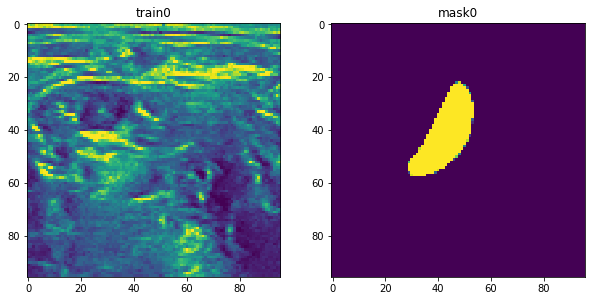

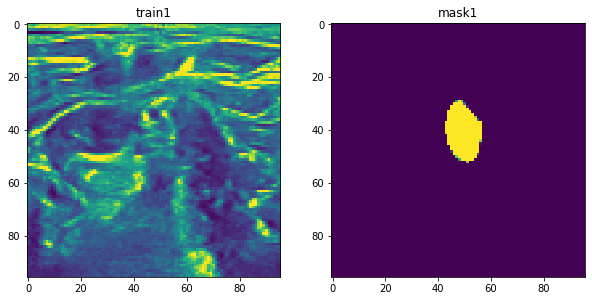

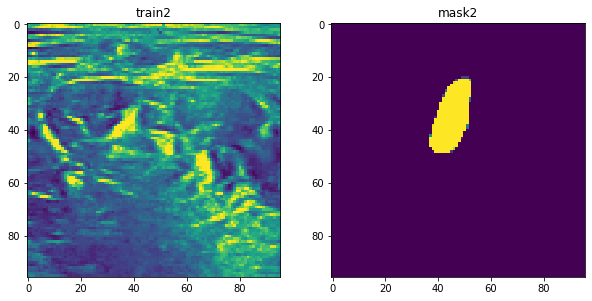

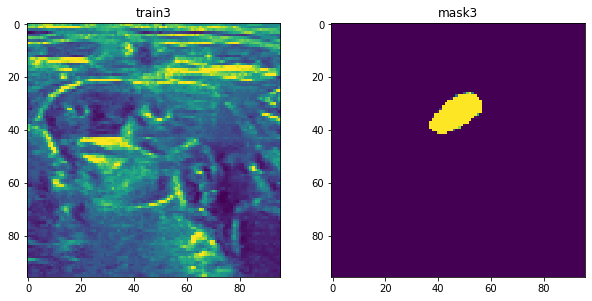

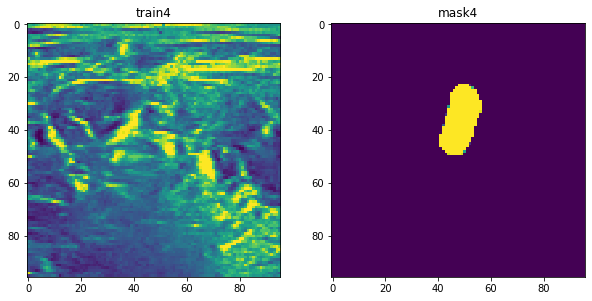

In [3]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
for i in range(5):
    #k=random.randint(0,train.shape[0])
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    
    plt.imshow(np.squeeze(train[i]))
    plt.title("train"+str(i))
    fig.add_subplot(1,2,2)
    plt.imshow(np.squeeze(train_mask[i]))
    plt.title("mask"+str(i))
    plt.show()


In [4]:
"""
import cv2

def resizing(im,sz):
    
    newimg=cv2.resize(im,(sz,sz))
    return newimg

def resized_train_val_split(X,Y,sz):
    resized_train=np.array([resizing(im,sz) for im in X], dtype=np.float16)
    resized_train_mask=np.array([resizing(ma,sz) for ma in Y],dtype=np.float16)
    print(resized_train.shape, resized_train_mask.shape)
    l=X.shape[0]-1
    howmany=int(l*0.2)
    test_indx=[random.randint(0,l) for i in range(howmany)]
    test=resized_train[test_indx]
    test_mask=resized_train_mask[test_indx]
    print(test.shape, test_mask.shape)
    resized_train=np.expand_dims(resized_train,-1)
    resized_train_mask=np.expand_dims(resized_train_mask,-1)
    test=np.expand_dims(test,-1)
    test_mask=np.expand_dims(test_mask,-1)
    return resized_train ,resized_train_mask , test, test_mask
"""

'\nimport cv2\n\ndef resizing(im,sz):\n    \n    newimg=cv2.resize(im,(sz,sz))\n    return newimg\n\ndef resized_train_val_split(X,Y,sz):\n    resized_train=np.array([resizing(im,sz) for im in X], dtype=np.float16)\n    resized_train_mask=np.array([resizing(ma,sz) for ma in Y],dtype=np.float16)\n    print(resized_train.shape, resized_train_mask.shape)\n    l=X.shape[0]-1\n    howmany=int(l*0.2)\n    test_indx=[random.randint(0,l) for i in range(howmany)]\n    test=resized_train[test_indx]\n    test_mask=resized_train_mask[test_indx]\n    print(test.shape, test_mask.shape)\n    resized_train=np.expand_dims(resized_train,-1)\n    resized_train_mask=np.expand_dims(resized_train_mask,-1)\n    test=np.expand_dims(test,-1)\n    test_mask=np.expand_dims(test_mask,-1)\n    return resized_train ,resized_train_mask , test, test_mask\n'

In [5]:
import time
import tensorflow.compat.v2 as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import * 
import tensorflow
import talos

Using TensorFlow backend.


In [6]:
from tensorflow.python.client import device_lib
def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        
        if "compute capability" in str(line):
            return True

print("tensorflow version is ", tf.__version__)

print("is Nvidia gpu present = ", check_tensor_core_gpu_present())


tensorflow version is  2.0.0
is Nvidia gpu present =  True


In [7]:
#disable  mix_precision for the first round of hyperparameter find tuning
mix_precision_enabled=False

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam , Nadam,Adamax
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision


smooth = 1.

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### customized unet loss function in order to ensure sucess and fast training 
def combined_dice_binary_loss(y_true,y_pred):
    def dice_loss(y_true,y_pred):
        numerator= 2 * tf.reduce_sum( y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true +y_pred, axis=(1,2,3))
        return tf.reshape(1-numerator/denominator, (-1,1,1))
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)



###################### build model
def get_unet(Xtrain, Ytrain, Xtest,Ytest,hp ):

    inputs = Input((96, 96, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    if mix_precision_enabled:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        #opt=tensorflow.compat.v2.train.experimental.enable_mixed_precision_graph_rewrite(opt)
    else:
        pass
    
    
    

    model.compile(optimizer=hp['opt'], loss=hp['loss'], metrics=[dice_coef])
    
    print(Xtrain.shape,Ytrain.shape,Xtest.shape,Ytest.shape)
    start=time.time()
    model_history = model.fit(Xtrain, Ytrain, batch_size=hp['batch_size'], epochs=hp['epochs'], verbose=1, shuffle=True,validation_data=(Xtest,Ytest),callbacks=[talos.utils.live()])    
       
    end=time.time()
    print("training took \n", round(end-start,5))
    print(" seconds")
    return model_history, model



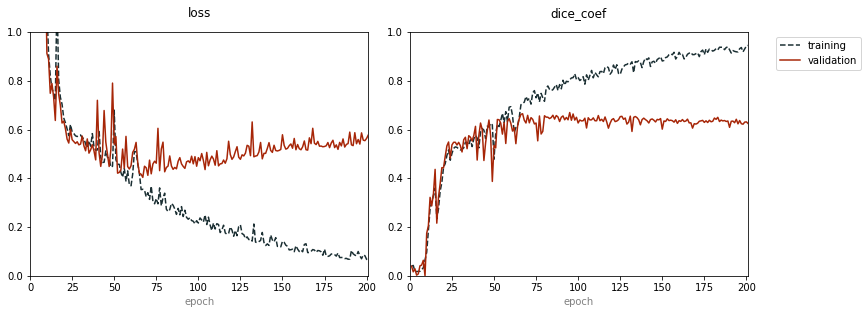

70/70 [==============================] - 1s 8ms/sample - loss: 0.0649 - dice_coef: 0.9449 - val_loss: 0.5774 - val_dice_coef: 0.6245
training took 
 112.45876
 seconds


100%|██████████| 10/10 [18:57<00:00, 113.71s/it]


In [9]:
################ resize training data
#Xtrain,Ytrain,_,_=resized_train_val_split(train,train_mask,96)
#print(np.min(Xtrain), np.max(Xtrain), np.min(Ytrain), np.max(Ytrain))

################ hyperparameter scanning configuration

hp = {'batch_size':[4,8,12,16,24],
      'epochs': [201],
      'opt': ['Adam','Adamax','Nadam'],
      'loss': [dice_coef_loss,combined_dice_binary_loss,'mse']}

t = talos.Scan(x=train,
               y=train_mask,
               model=get_unet,
               params=hp,
               experiment_name='autoparamstune',
               round_limit=10)

In [10]:
# accessing the results data frame
t.data.head()


,round_epochs,loss,dice_coef,val_loss,val_dice_coef,batch_size,epochs,loss,opt
0,201,0.070116,0.938265,0.543012,0.639697,8,201,<function combined_dice_binary_loss at 0x7f34a...,Adamax
1,201,-0.000316,0.000316,-0.000386,0.000434,12,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
2,201,-0.000261,0.000300,-0.000256,0.000258,16,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
3,201,-0.000158,0.000158,-0.000260,0.000416,24,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
4,201,-0.000315,0.000316,-0.000386,0.000434,12,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adam


In [11]:
# accessing epoch entropy values for each round
t.learning_entropy

,loss,dice_coef
0,0.260801,0.006136
1,0.260667,0.247418
2,0.479156,0.423164
3,0.074085,0.084693
4,0.176555,0.180017
5,0.268703,0.005670
6,0.411272,0.008771
7,0.245683,0.006369
8,0.175322,0.006098
9,0.293848,0.012846


In [12]:
# access the summary details
t.details

experiment_name          autoparamstune
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            12/27/19/13:27
x_shape                (100, 96, 96, 1)
y_shape                (100, 96, 96, 1)
dtype: object

In [13]:
# accessing the saved models
t.saved_models

['{"class_name": "Model", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 96, 96, 1], "dtype": "float32", "sparse": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1],

In [14]:
# accessing the saved weights for models
#t.saved_weights

In [15]:

# use Scan object as input
analyze_object = talos.Analyze(t)

# access the dataframe with the results
analyze_object.data

,round_epochs,loss,dice_coef,val_loss,val_dice_coef,batch_size,epochs,loss,opt
0,201,0.070116,0.938265,0.543012,0.639697,8,201,<function combined_dice_binary_loss at 0x7f34a...,Adamax
1,201,-0.000316,0.000316,-0.000386,0.000434,12,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
2,201,-0.000261,0.000300,-0.000256,0.000258,16,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
3,201,-0.000158,0.000158,-0.000260,0.000416,24,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adamax
4,201,-0.000315,0.000316,-0.000386,0.000434,12,201,<function dice_coef_loss at 0x7f34a9ae5a60>,Adam
5,201,0.062368,0.944917,0.564772,0.626551,4,201,<function combined_dice_binary_loss at 0x7f34a...,Adamax
6,201,0.043757,0.959574,0.632190,0.625674,4,201,<function combined_dice_binary_loss at 0x7f34a...,Adam
7,201,0.101532,0.914814,0.592577,0.620362,16,201,<function combined_dice_binary_loss at 0x7f34a...,Adamax
8,201,0.111629,0.904570,0.486669,0.625929,24,201,<function combined_dice_binary_loss at 0x7f34a...,Adamax
9,201,0.064888,0.944882,0.577382,0.624523,16,201,<function combined_dice_binary_loss at 0x7f34a...,Nadam


In [16]:
tf.keras.backend.clear_session()
time.sleep(10)


In [17]:
#TODO: add mixed precision if possible
